# Food-101: v2.2 - Objetivo 80% Accuracy

Mejoras: Arquitectura profunda + BatchNorm + Mixup/CutMix + LR Scheduler + Regularización agresiva

In [15]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [16]:
# Mixed precision DESACTIVADO (causa inestabilidad numérica)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')
print('Mixed Precision: DESACTIVADO (float32 para estabilidad)')

Mixed Precision: DESACTIVADO (float32 para estabilidad)


In [17]:
# Configuración
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES_TO_USE = 5
AUTOTUNE = tf.data.AUTOTUNE

print(f'IMG_SIZE: {IMG_SIZE} | BATCH_SIZE: {BATCH_SIZE} | CLASES: {NUM_CLASSES_TO_USE}')

IMG_SIZE: 224 | BATCH_SIZE: 64 | CLASES: 5


In [18]:
# Cargar dataset
(train_ds, val_ds), info = tfds.load(
    'food101',
    split=['train', 'validation'],
    with_info=True,
    as_supervised=True
)

class_names = info.features['label'].names
print(f'Dataset: {len(class_names)} clases totales')

if NUM_CLASSES_TO_USE < 101:
    train_ds = train_ds.filter(lambda img, label: label < NUM_CLASSES_TO_USE)
    val_ds = val_ds.filter(lambda img, label: label < NUM_CLASSES_TO_USE)
    num_classes = NUM_CLASSES_TO_USE
    class_names = class_names[:NUM_CLASSES_TO_USE]
else:
    num_classes = len(class_names)

print(f'Usando: {num_classes} clases - {class_names}')

Dataset: 101 clases totales
Usando: 5 clases - ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']


In [19]:
# Funciones de preprocessing y augmentation SIMPLIFICADO
def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

# Augmentation SIMPLE (solo flip - Mixup/CutMix hace el resto)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
])

def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label

# Mixup
def mixup(image, label, alpha=0.2):
    batch_size = tf.shape(image)[0]
    dist = tf.compat.v1.distributions.Beta(alpha, alpha)
    lam = dist.sample(1)[0]
    
    indices = tf.random.shuffle(tf.range(batch_size))
    mixed_image = lam * image + (1 - lam) * tf.gather(image, indices)
    
    label_a = tf.one_hot(label, NUM_CLASSES_TO_USE)
    label_b = tf.one_hot(tf.gather(label, indices), NUM_CLASSES_TO_USE)
    mixed_label = lam * label_a + (1 - lam) * label_b
    
    return mixed_image, mixed_label

# CutMix
def cutmix(image, label, alpha=1.0):
    batch_size = tf.shape(image)[0]
    image_height, image_width = IMG_SIZE, IMG_SIZE
    
    dist = tf.compat.v1.distributions.Beta(alpha, alpha)
    lam = dist.sample(1)[0]
    
    cut_ratio = tf.sqrt(1.0 - lam)
    cut_h = tf.cast(image_height * cut_ratio, tf.int32)
    cut_w = tf.cast(image_width * cut_ratio, tf.int32)
    
    cy = tf.random.uniform([], 0, image_height, dtype=tf.int32)
    cx = tf.random.uniform([], 0, image_width, dtype=tf.int32)
    
    y1 = tf.clip_by_value(cy - cut_h // 2, 0, image_height)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, image_height)
    x1 = tf.clip_by_value(cx - cut_w // 2, 0, image_width)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, image_width)
    
    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_image = tf.gather(image, indices)
    
    mask = tf.concat([
        tf.zeros([batch_size, y1, image_width, 3]),
        tf.concat([
            tf.zeros([batch_size, y2-y1, x1, 3]),
            tf.ones([batch_size, y2-y1, x2-x1, 3]),
            tf.zeros([batch_size, y2-y1, image_width-x2, 3])
        ], axis=2),
        tf.zeros([batch_size, image_height-y2, image_width, 3])
    ], axis=1)
    
    mixed_image = image * (1 - mask) + shuffled_image * mask
    
    area = tf.cast((x2 - x1) * (y2 - y1), tf.float32)
    total_area = tf.cast(image_height * image_width, tf.float32)
    lam_adjusted = 1.0 - (area / total_area)
    
    label_a = tf.one_hot(label, NUM_CLASSES_TO_USE)
    label_b = tf.one_hot(tf.gather(label, indices), NUM_CLASSES_TO_USE)
    mixed_label = lam_adjusted * label_a + (1 - lam_adjusted) * label_b
    
    return mixed_image, mixed_label

print('Augmentation SIMPLIFICADO: Solo RandomFlip + Mixup/CutMix')

Augmentation SIMPLIFICADO: Solo RandomFlip + Mixup/CutMix


In [20]:
# Pipeline con mixup/cutmix
train_dataset = (
    train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

def apply_mixup_cutmix(images, labels):
    # Cast images to float32 to avoid type mismatch with mixup/cutmix operations
    images = tf.cast(images, tf.float32)
    choice = tf.random.uniform([], 0, 1)
    if choice < 0.25:
        return mixup(images, labels, alpha=0.2)
    elif choice < 0.5:
        return cutmix(images, labels, alpha=1.0)
    else:
        return images, tf.one_hot(labels, NUM_CLASSES_TO_USE)

train_dataset = train_dataset.map(apply_mixup_cutmix, num_parallel_calls=AUTOTUNE)

val_dataset = (
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES_TO_USE)))
    .prefetch(AUTOTUNE)
)

print('Pipeline: Mixup 25% | CutMix 25% | Normal 50%')

Pipeline: Mixup 25% | CutMix 25% | Normal 50%


In [21]:
# Arquitectura BALANCEADA: Dropout solo en bloques profundos
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # Bloque 1: 32 filtros - SIN dropout (deja aprender features básicas)
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),

    # Bloque 2: 64 filtros - SIN dropout
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),

    # Bloque 3: 128 filtros - Dropout 0.2 (regularización moderada)
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    # Bloque 4: 256 filtros - Dropout 0.2
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),

    # Clasificador - Dropout 0.3 (no 0.5)
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()
total_params = model.count_params()
print(f'\nParams: {total_params:,} | Dropout BALANCEADO: bloques 3-4 (0.2), Dense (0.3)')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,388,837 (5.30 MB)

 Trainable params: 1,387,877 (5.29 MB)

 Non-trainable params: 960 (3.75 KB)


Params: 1,388,837 | Dropout BALANCEADO: bloques 3-4 (0.2), Dense (0.3)


In [22]:
# Compilar SIN label smoothing (Mixup/CutMix ya suavizan labels)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # LR reducido
    loss=tf.keras.losses.CategoricalCrossentropy(),  # SIN label_smoothing
    metrics=['accuracy']
)

print('Optimizer: Adam (LR 0.0005) | Loss: CategoricalCrossentropy (sin label smoothing)')

Optimizer: Adam (LR 0.0005) | Loss: CategoricalCrossentropy (sin label smoothing)


In [23]:
# LR Scheduler AJUSTADO: Warmup + Cosine Annealing con LR más bajo
class WarmupCosineDecay(tf.keras.callbacks.Callback):
    def __init__(self, max_lr=0.0005, min_lr=0.00001, warmup_epochs=5, total_epochs=60):
        super().__init__()
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            lr = self.max_lr * (epoch + 1) / self.warmup_epochs
        else:
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + tf.cos(np.pi * progress))
        
        optimizer = self.model.optimizer
        if hasattr(optimizer, 'learning_rate'):
            optimizer.learning_rate.assign(lr)
        
        if epoch < 5 or epoch % 10 == 0:
            print(f'Epoch {epoch+1}: LR = {lr:.6f}')

lr_scheduler = WarmupCosineDecay(max_lr=0.0005, min_lr=0.00001, warmup_epochs=5, total_epochs=60)
print('LR Scheduler: Warmup 0→0.0005 (epochs 1-5) + Cosine 0.0005→0.00001 (epochs 6-60)')

LR Scheduler: Warmup 0→0.0005 (epochs 1-5) + Cosine 0.0005→0.00001 (epochs 6-60)


In [24]:
# Callbacks y entrenamiento
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,  # Más tolerante (antes era 10)
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_v2.3.keras',  # Nueva versión balanceada
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

EPOCHS = 60

print(f'\nv2.3 BALANCEADA - Entrenamiento: {EPOCHS} epochs, early stopping patience=15')
print('Cambios vs v2.2:')
print('  ✓ Mixed precision: DESACTIVADO')
print('  ✓ Label smoothing: ELIMINADO')
print('  ✓ Augmentation: SIMPLIFICADO (solo flip)')
print('  ✓ Dropout: REDUCIDO (bloques 3-4: 0.2, Dense: 0.3)')
print('  ✓ LR: REDUCIDO (0.0005 vs 0.001)')
print('\nEsperado: 60-75% accuracy\n')

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
    verbose=1
)


v2.3 BALANCEADA - Entrenamiento: 60 epochs, early stopping patience=15
Cambios vs v2.2:
  ✓ Mixed precision: DESACTIVADO
  ✓ Label smoothing: ELIMINADO
  ✓ Augmentation: SIMPLIFICADO (solo flip)
  ✓ Dropout: REDUCIDO (bloques 3-4: 0.2, Dense: 0.3)
  ✓ LR: REDUCIDO (0.0005 vs 0.001)

Esperado: 60-75% accuracy

Epoch 1: LR = 0.000100
Epoch 1/60
     59/Unknown 296s 5s/step - accuracy: 0.2474 - loss: 2.1411

/opt/homebrew/anaconda3/envs/ml_env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to best_model_v2.3.keras
59/59 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - accuracy: 0.2483 - loss: 2.1373 - val_accuracy: 0.2000 - val_loss: 1.7284
Epoch 2: LR = 0.000200
Epoch 2/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4245 - loss: 1.5606
Epoch 2: val_accuracy did not improve from 0.20000
59/59 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.4243 - loss: 1.5604 - val_accuracy: 0.2000 - val_loss: 2.0163
Epoch 3: LR = 0.000300
Epoch 3/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4333 - loss: 1.5103
Epoch 3: val_accuracy did not improve from 0.20000
59/59 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.4334 - loss: 1.5095 - val_accuracy: 0.2000 - val_loss: 2.5297
Epoch 4: LR = 0.000400
Epoch 4/60
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4605 - loss: 1.3875
Epoch 4: val_accuracy did not improve from 0.20000
59/59 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.4605 - loss: 1.3878 - val_accuracy:

In [25]:
# Evaluación
test_loss, test_acc = model.evaluate(val_dataset)
print(f'\nValidation Loss: {test_loss:.4f} | Validation Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%)')

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 434ms/step - accuracy: 0.8232 - loss: 0.5667

Validation Loss: 0.5920 | Validation Accuracy: 0.8096 (81.0%)


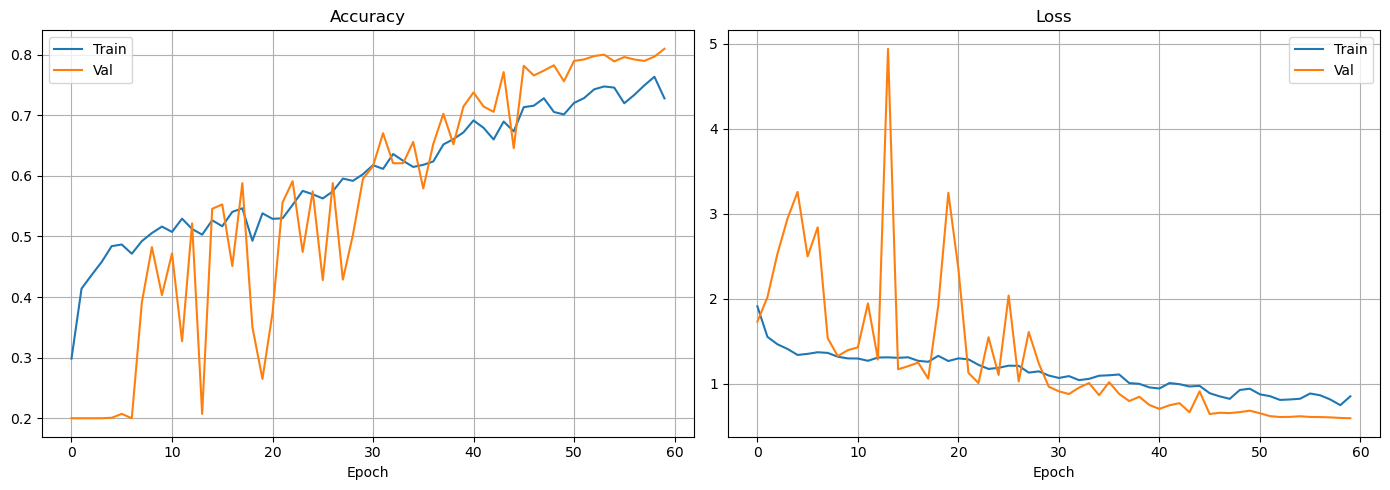

In [26]:
# Gráficas de entrenamiento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

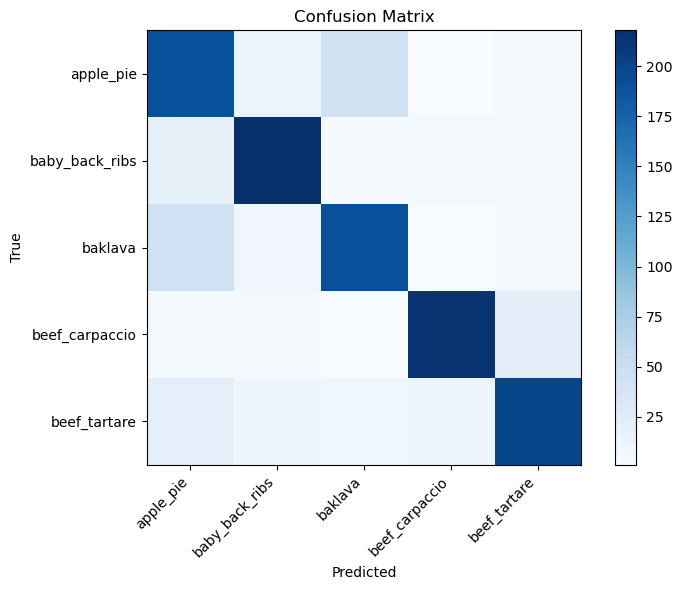


Classification Report:
                precision    recall  f1-score   support

     apple_pie      0.679     0.760     0.717       250
baby_back_ribs      0.852     0.872     0.862       250
       baklava      0.780     0.764     0.772       250
beef_carpaccio      0.915     0.856     0.884       250
  beef_tartare      0.847     0.796     0.821       250

      accuracy                          0.810      1250
     macro avg      0.814     0.810     0.811      1250
  weighted avg      0.814     0.810     0.811      1250



In [27]:
# Matriz de confusión y reporte
y_true = []
y_pred = []

for images, labels_onehot in val_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(tf.argmax(labels_onehot, axis=1).numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

In [28]:
print(f'\n=== RESULTADOS v2.3 BALANCEADA ({num_classes} clases) ===')
print(f'Train: {history.history["accuracy"][-1]:.3f} | Val: {test_acc:.3f}')
print(f'Overfitting gap: {(history.history["accuracy"][-1] - test_acc)*100:.1f}%')
print(f'\nv2.0: 20% | v2.1: 38% | v2.2: 20% (colapsó) | v2.3: {test_acc*100:.1f}%')
print(f'Objetivo 80%: {"✓ ALCANZADO" if test_acc >= 0.80 else f"Faltan {(0.80-test_acc)*100:.1f} puntos"}')


=== RESULTADOS v2.3 BALANCEADA (5 clases) ===
Train: 0.728 | Val: 0.810
Overfitting gap: -8.2%

v2.0: 20% | v2.1: 38% | v2.2: 20% (colapsó) | v2.3: 81.0%
Objetivo 80%: ✓ ALCANZADO
